# Background

- Suppose that we are statistical consultants hired by a client to investigate the association between advertising and sales of a particular product.
- We are provided the dataset consists of the **sales** of one particular product in 200 diferent markets, along with advertising budgets for the product in each of those markets for three diferent media: **TV**, **Radio**, and **newspaper**.
- Client has **full control** of advertising expenses in each of the three media.
- If we determine that there is an association between advertising and alses, then we can instruct our client to adjust advertising budgets, thereby indirectly increasing sales.
- **OBJECTIVE**: Our goal is to develop an accurate model that can be used to predict sales on the basis of the three media budgets.

# Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import t
from IQR import plot_iqr_outliers

from sklearn.linear_model import LinearRegression

# Load Dataset

- '**Unnamed: 0**': additional index(Confirmed with Client, and we can drop it)
- '**TV**': TV Advertising Spends, and unit is in thousands of dollars.
- '**Sales**':The quantities of product sale at corresponding budget of three advertising approaches, and unit is in thousand of dollars(Notice is not dollars).

In [2]:
df = pd.read_csv('Advertising_simple.csv')
# drop feature 'Unnamed:0'
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,TV,Sales
0,230.1,22.1
1,44.5,10.4
2,17.2,9.3
3,151.5,18.5
4,180.8,12.9


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TV,200.0,147.0425,85.854236,0.7,74.375,149.75,218.825,296.4
Sales,200.0,14.0225,5.217457,1.6,10.375,12.90,17.400,27.0


# Data Visualization

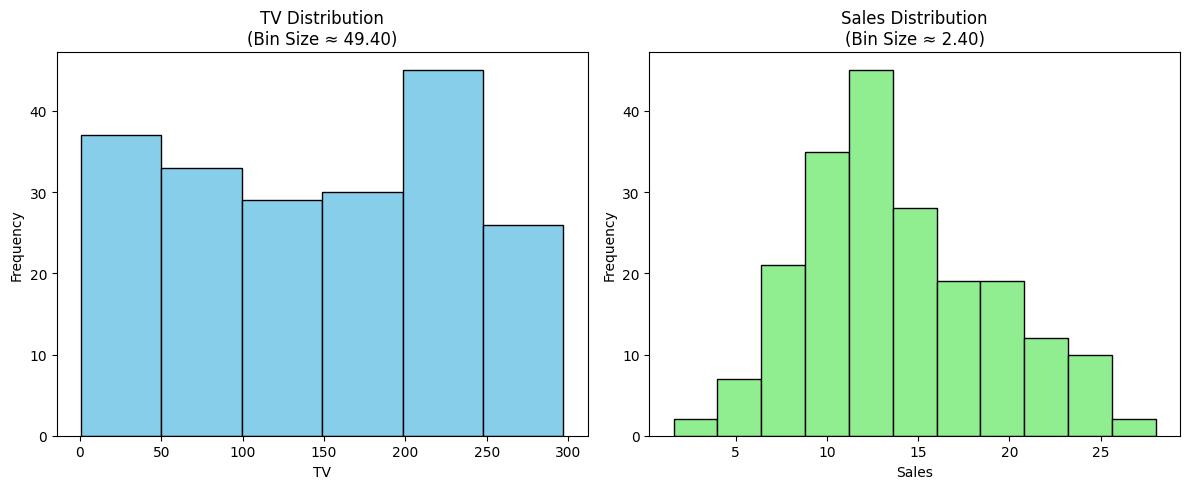

In [9]:
# Freedman–Diaconis rule function (returns bin edges and bin size)
def compute_bin_edges(data):
    q25, q75 = np.percentile(data, [25, 75])
    iqr = q75 - q25
    bin_width = 2 * iqr / (len(data) ** (1/3))
    if bin_width == 0:  # fallback
        bin_width = (data.max() - data.min()) / 10
    bins = np.arange(data.min(), data.max() + bin_width, bin_width)
    return bins, bin_width

# Compute bin edges and size
tv_bins, tv_bin_width = compute_bin_edges(df['TV'])
sales_bins, sales_bin_width = compute_bin_edges(df['Sales'])

# Plot
plt.figure(figsize=(12, 5))

# 2. Histogram: TV
plt.subplot(1, 2, 1)
plt.hist(df['TV'], bins=tv_bins, color='skyblue', edgecolor='black')
plt.xlabel("TV")
plt.ylabel("Frequency")
plt.title(f"TV Distribution\n(Bin Size ≈ {tv_bin_width:.2f})")

# 3. Histogram: Sales
plt.subplot(1, 2, 2)
plt.hist(df['Sales'], bins=sales_bins, color='lightgreen', edgecolor='black')
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.title(f"Sales Distribution\n(Bin Size ≈ {sales_bin_width:.2f})")

plt.tight_layout()
plt.show()

# Check Noise and Denoise

- Using IQR Method to detect the potential noise. [Explanation from Wikipedia](https://en.wikipedia.org/wiki/Interquartile_range)
- After calculating the IQR bound, we can conclude that there is no potential noise in our dataset.

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1200/1*0MPDTLn8KoLApoFvI0P2vQ.png" alt="IQR" width="700" height="350"/>
</p>


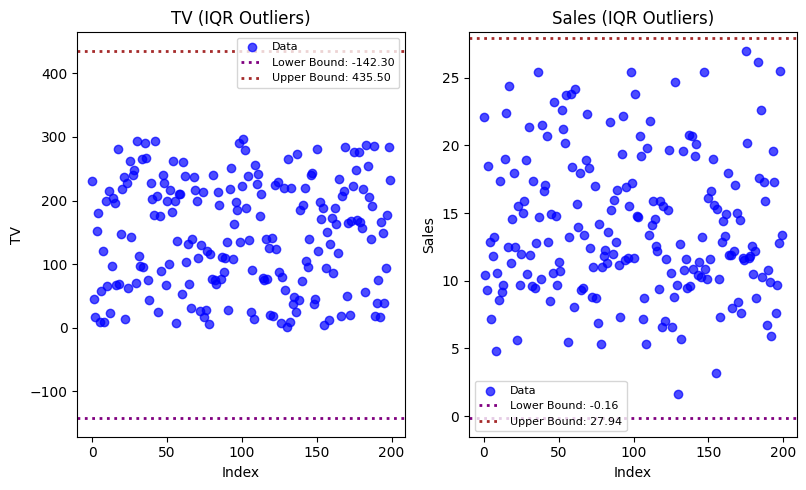

In [4]:
plot_iqr_outliers(df)  # all features

# TV V.S. Sales Correlation

- The positive correlation between TV Spend is strong, and this is a strong evidence that we may consider to use linear regression to complete the task.

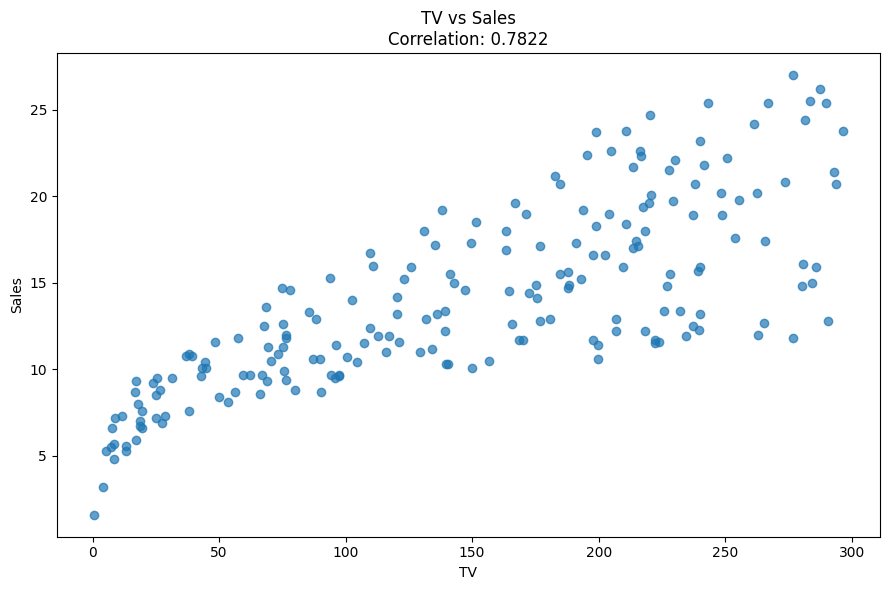

In [13]:
# Calculate correlation
tv_corr = df['TV'].corr(df['Sales'])

# Plot
plt.figure(figsize=(9, 6))
plt.scatter(df['TV'], df['Sales'], alpha=0.7)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title(f"TV vs Sales\nCorrelation: {tv_corr:.4f}")
plt.tight_layout()
plt.show()

# Linear Regression

We will calculate the most optimized coefficient by doing multiple approach:
- Manually calculating Ordinary Least Square(OLS).
- NumPy
- Scikit-Learn

## Manually Calculate OLS

In [8]:
def OLS(feature, predict):
    X = df[feature]
    y = df[predict]
    x_mean = X.mean()
    y_mean = y.mean()

    df['x_diff'] = X - x_mean
    df['y_diff'] = y - y_mean
    df['mult'] = df['x_diff'] * df['y_diff']
    df['x_diff_square'] = df['x_diff'] ** 2

    B1_slope = df['mult'].sum() / df['x_diff_square'].sum()
    B0_Intercept = y_mean - B1_slope * x_mean

    # Drop the temporary columns
    df.drop(columns=['x_diff', 'y_diff', 'mult', 'x_diff_square'], inplace=True)

    return B0_Intercept, B1_slope

def predict_sales(feature_value,B0, B1):
    return B0 + B1 * feature_value

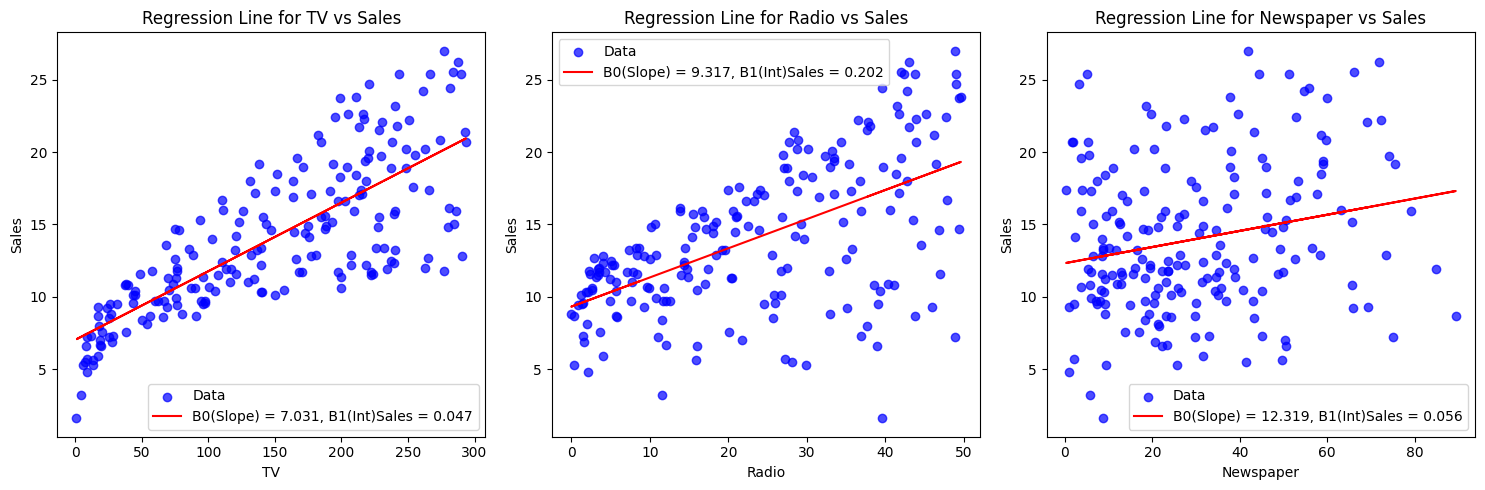

In [9]:
plt.figure(figsize=(15, 5))
for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        B0, B1 = OLS(feature, 'Sales')
        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
        equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
        plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()
plt.tight_layout()
plt.show()

## Manually Calculate Gradient Descend


Feature: TV
  Optimized B0 (Intercept): 7.0131
  Optimized B1 (Slope):     0.0473

Feature: Radio
  Optimized B0 (Intercept): 9.2936
  Optimized B1 (Slope):     0.2011

Feature: Newspaper
  Optimized B0 (Intercept): 12.2888
  Optimized B1 (Slope):     0.0557


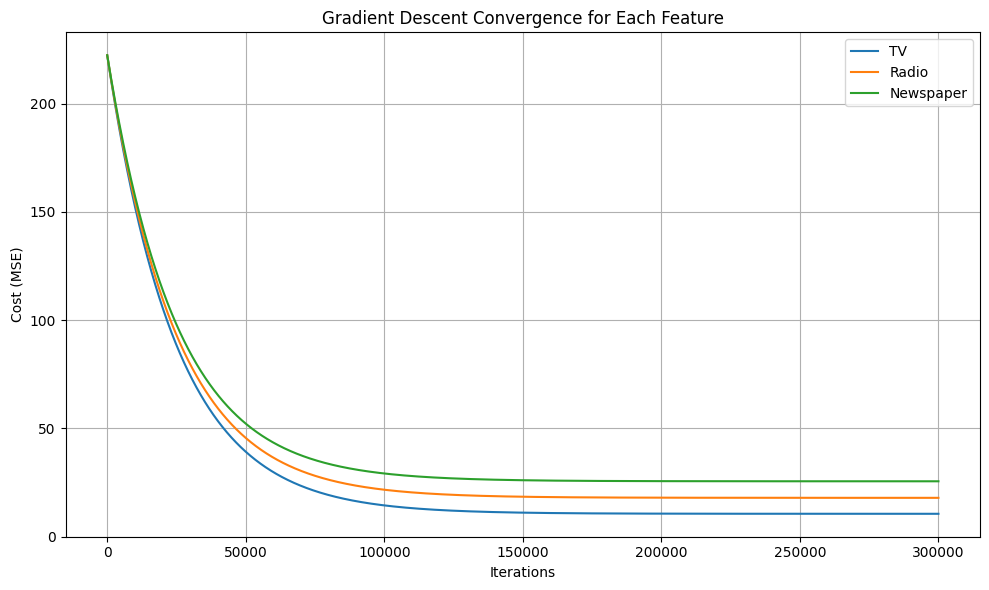

In [18]:
features = [col for col in df.columns if col != 'Sales']
y = df["Sales"].values
alpha = 0.00001
epochs = 300000
n = len(y)

results = {}

for feature in features:
    X_raw = df[feature].values
    X = (X_raw - np.mean(X_raw)) / np.std(X_raw)  # 标准化

    B0, B1 = 0, 0
    cost_history = []

    # Batch Gradient Descent
    for _ in range(epochs):
        y_pred = B0 + B1 * X
        error = y - y_pred

        dB0 = -2 * np.sum(error) / n
        dB1 = -2 * np.sum(error * X) / n

        B0 -= alpha * dB0
        B1 -= alpha * dB1

        cost = np.mean(error ** 2)
        cost_history.append(cost)

    # 转换为原始尺度
    B1_original = B1 / np.std(X_raw)
    B0_original = B0 - B1_original * np.mean(X_raw)

    results[feature] = {
        'B0': B0_original,
        'B1': B1_original,
        'cost_history': cost_history
    }

    print(f"\nFeature: {feature}")
    print(f"  Optimized B0 (Intercept): {B0_original:.4f}")
    print(f"  Optimized B1 (Slope):     {B1_original:.4f}")

# 可视化每个特征的收敛曲线（可选）
plt.figure(figsize=(10, 6))
for feature in features:
    plt.plot(results[feature]['cost_history'], label=feature)
plt.xlabel("Iterations")
plt.ylabel("Cost (MSE)")
plt.title("Gradient Descent Convergence for Each Feature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## NumPy

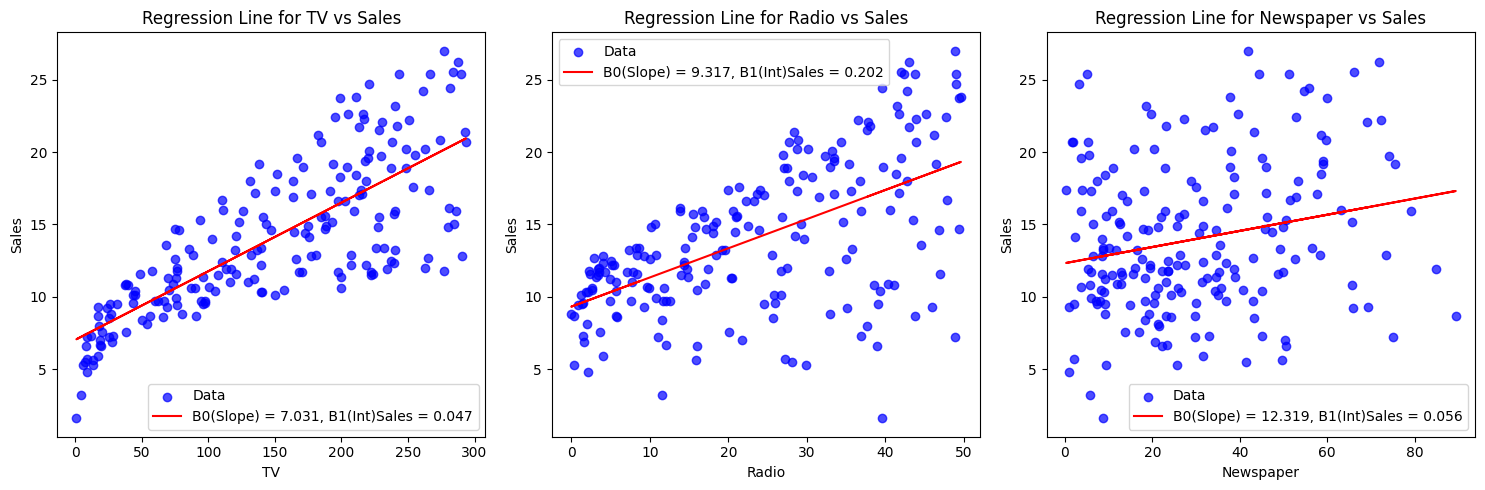

In [10]:
plt.figure(figsize=(15, 5))
y = df['Sales']
for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        X = df[feature]
        B1, B0 = np.polyfit(X,y,deg=1) # sovling 1st degree polynomial function to find B1 and B0
        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], df['Sales'], color='blue', label='Data', alpha=0.7)
        equation_label = f"B0(Slope) = {B0:.3f}, B1(Int)Sales = {B1:.3f}"
        plt.plot(df[feature], B0 + B1 * df[feature], color='red', label=equation_label)
        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()
plt.tight_layout()
plt.show()

## Scikit-Learning

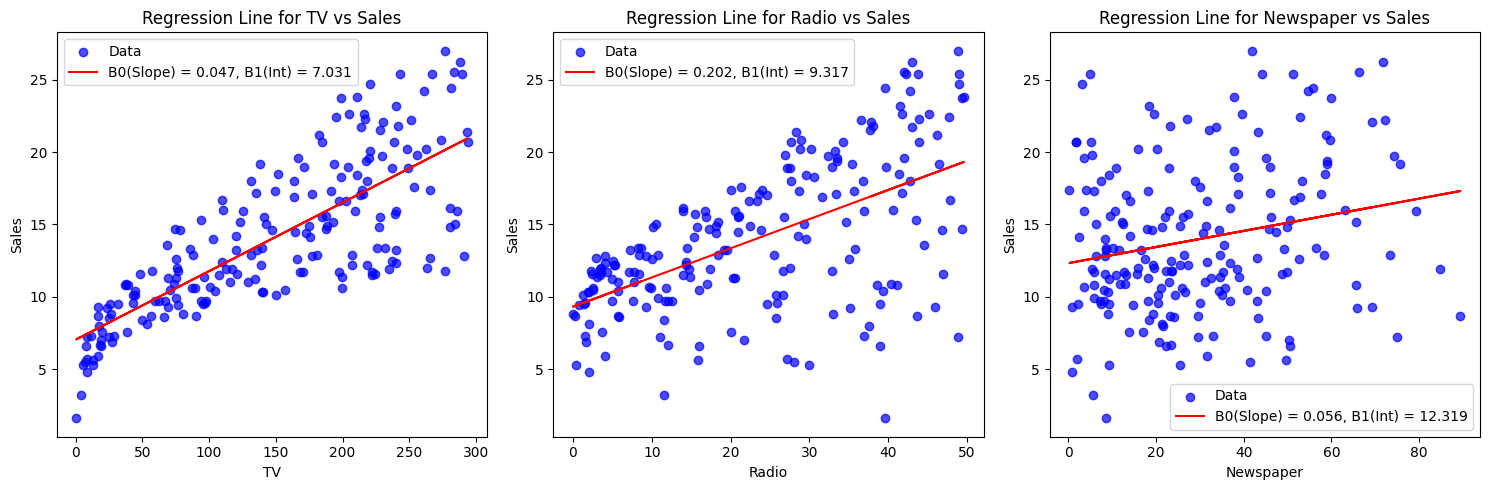

In [11]:
plt.figure(figsize=(15, 5))
y = df['Sales']

for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        X = df[[feature]]  # 2D shape required for sklearn
        model = LinearRegression()
        model.fit(X, y)

        B0 = model.intercept_
        B1 = model.coef_[0]

        plt.subplot(1, 3, i + 1)
        plt.scatter(df[feature], y, color='blue', label='Data', alpha=0.7)

        equation_label = f"B0(Slope) = {B1:.3f}, B1(Int) = {B0:.3f}"
        plt.plot(df[feature], model.predict(X), color='red', label=equation_label)

        plt.xlabel(f'{feature}')
        plt.ylabel('Sales')
        plt.title(f'Regression Line for {feature} vs Sales')
        plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

## Residual Standard Error(RSE) and $R^2$ Statistic

- Actual sales in the market deviate from the true regression line by 3260 Units, on average.
- If coefficient(B0 & B1) are accurate, the prediction of sales on the basis of TV advertising would still be off 3260 units.
- Whether or not 3260 units is an acceptable prediction error depends on the problem context.
- The average value of sales is around 14,000 units, and so the percentage error is 3260/14000 = 23%.

In [14]:
y = df['Sales']
metrics_list = []

for i, feature in enumerate(df.columns):
    if feature != 'Sales':
        X = df[[feature]]
        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)
        B0 = model.intercept_
        B1 = model.coef_[0]

        n = len(y)
        mse = mean_squared_error(y, y_pred)
        rse = np.sqrt(mse * n / (n - 2))
        r2 = r2_score(y, y_pred)
        metrics_list.append((feature, rse, r2))

# 打印每个特征的 RSE 和 R²
print("Metrics per feature:")
for feature, rse, r2 in metrics_list:
    print(f"{feature} - RSE: {rse:.3f}, R²: {r2:.3f}")

Metrics per feature:
TV - RSE: 3.266, R²: 0.607
Radio - RSE: 4.256, R²: 0.333
Newspaper - RSE: 5.082, R²: 0.048


# Evaluate Coefficient Accuracy and Confidence Interval

In [15]:
# 假设 df 包含 'Sales' 和 3 个特征
features = [col for col in df.columns if col != 'Sales']

for feature in features:
    x = df[feature]
    y = df['Sales']
    x_mean = x.mean()
    y_mean = y.mean()

    x_diff = x - x_mean
    y_diff = y - y_mean

    B1 = (x_diff * y_diff).sum() / (x_diff ** 2).sum()
    B0 = y_mean - B1 * x_mean

    # 预测和残差
    y_pred = B1 * x + B0
    residuals = y - y_pred
    n = len(df)
    
    RSS = (residuals ** 2).sum()
    RSE = np.sqrt(RSS / (n - 2))

    SE_B1 = RSE / np.sqrt((x_diff ** 2).sum())
    SE_B0 = RSE * np.sqrt((1 / n) + (x_mean ** 2 / (x_diff ** 2).sum()))

    # 置信区间范围（近似 95%）
    B1_low, B1_high = B1 - 2 * SE_B1, B1 + 2 * SE_B1
    B0_low, B0_high = B0 - 2 * SE_B0, B0 + 2 * SE_B0

    print(f"\nFeature: {feature}")
    print(f"  Slope (B1): {B1:.4f}, Intercept (B0): {B0:.4f}")
    print(f"  SE of B1: {SE_B1:.4f}, SE of B0: {SE_B0:.4f}")
    print(f"  B1 range: [{B1_low:.4f}, {B1_high:.4f}]")
    print(f"  B0 range: [{B0_low:.4f}, {B0_high:.4f}]")


Feature: TV
  Slope (B1): 0.0474, Intercept (B0): 7.0306
  SE of B1: 0.0027, SE of B0: 0.4620
  B1 range: [0.0419, 0.0528]
  B0 range: [6.1066, 7.9545]

Feature: Radio
  Slope (B1): 0.2016, Intercept (B0): 9.3166
  SE of B1: 0.0204, SE of B0: 0.5605
  B1 range: [0.1608, 0.2424]
  B0 range: [8.1957, 10.4376]

Feature: Newspaper
  Slope (B1): 0.0558, Intercept (B0): 12.3193
  SE of B1: 0.0177, SE of B0: 0.6392
  B1 range: [0.0204, 0.0912]
  B0 range: [11.0410, 13.5977]


# Hypothesis Test

In [17]:
features = [col for col in df.columns if col != 'Sales']
y = df['Sales']
n = len(y)
dof = n - 2  # 自由度

for feature in features:
    X = df[feature].values.reshape(-1, 1)
    
    # 训练模型
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    RSS = np.sum((y - y_pred) ** 2)
    RSE = np.sqrt(RSS / dof)

    # 标准误差
    x_diff_sq_sum = np.sum((X - np.mean(X)) ** 2)
    SE_B1 = RSE / np.sqrt(x_diff_sq_sum)
    SE_B0 = RSE * np.sqrt((1 / n) + (np.mean(X) ** 2 / x_diff_sq_sum))

    # t 值
    B1 = model.coef_[0]
    B0 = model.intercept_
    t_B1 = B1 / SE_B1
    t_B0 = B0 / SE_B0

    # p 值（双尾）
    p_B1 = 2 * (1 - t.cdf(np.abs(t_B1), df=dof))
    p_B0 = 2 * (1 - t.cdf(np.abs(t_B0), df=dof))

    # 输出
    print(f"\nFeature: {feature}")
    print(f"  B1 (Slope) = {B1:.4f}, SE_B1 = {SE_B1:.4f}, t = {t_B1:.4f}, p = {p_B1:.4e}")
    print(f"  B0 (Intercept) = {B0:.4f}, SE_B0 = {SE_B0:.4f}, t = {t_B0:.4f}, p = {p_B0:.4e}")

    if p_B1 < 0.05:
        print("  ✅ Slope is statistically significant (reject H0)")
    else:
        print("  ❌ Slope is NOT statistically significant (fail to reject H0)")


Feature: TV
  B1 (Slope) = 0.0474, SE_B1 = 0.0027, t = 17.4001, p = 0.0000e+00
  B0 (Intercept) = 7.0306, SE_B0 = 0.4620, t = 15.2189, p = 0.0000e+00
  ✅ Slope is statistically significant (reject H0)

Feature: Radio
  B1 (Slope) = 0.2016, SE_B1 = 0.0204, t = 9.8840, p = 0.0000e+00
  B0 (Intercept) = 9.3166, SE_B0 = 0.5605, t = 16.6224, p = 0.0000e+00
  ✅ Slope is statistically significant (reject H0)

Feature: Newspaper
  B1 (Slope) = 0.0558, SE_B1 = 0.0177, t = 3.1506, p = 1.8845e-03
  B0 (Intercept) = 12.3193, SE_B0 = 0.6392, t = 19.2740, p = 0.0000e+00
  ✅ Slope is statistically significant (reject H0)
